Simulating 1*1 circuit
Simulating 1*2 circuit
Simulating 1*3 circuit
Simulating 1*4 circuit
Simulating 1*5 circuit
Simulating 1*6 circuit
Simulating 1*7 circuit
Simulating 1*8 circuit
Simulating 1*9 circuit
Simulating 2*5 circuit
Simulating 2*6 circuit
Simulating 2*7 circuit
Simulating 2*8 circuit
Simulating 2*9 circuit
Simulating 3*5 circuit
Simulating 3*7 circuit
Simulating 3*8 circuit
Simulating 4*5 circuit


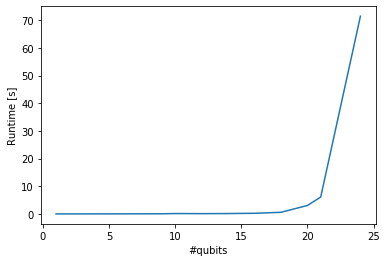

In [45]:
from qcg.generators import gen_supremacy
from qiskit import *
from time import time
import matplotlib.pyplot as plt
import numpy as np

def reverseBits(num,bitSize):
    binary = bin(num)
    reverse = binary[-1:1:-1] 
    reverse = reverse + (bitSize - len(reverse))*'0'
    return int(reverse,2)

def simulate_circ(circ,num_shots=1024):
    c = ClassicalRegister(len(circ.qubits), 'c')
    meas = QuantumCircuit(circ.qregs[0], c)
    meas.barrier(circ.qubits)
    meas.measure(circ.qubits,c)
    qc = circ+meas
    
    backend_sim = BasicAer.get_backend('qasm_simulator')
    job_sim = execute(qc, backend_sim, shots=num_shots)
    result_sim = job_sim.result()
    counts = result_sim.get_counts(qc)
    prob_ordered = [0 for x in range(np.power(2,len(circ.qubits)))]
#     print('Total %d states'%len(prob_ordered))
    for state in counts:
#         print('state is:',type(state),state,int(state,2))
        reversed_state = reverseBits(int(state,2),len(circ.qubits))
#         print('{} reversed_state = {}'.format(state,reversed_state))
        prob_ordered[reversed_state] = counts[state]/num_shots
    return prob_ordered

times = []
num_qubits = []
dimension_limit = 10
for i in range(1,dimension_limit):
    for j in range(i,dimension_limit):
        if i*j<=24 and i*j not in num_qubits:
            print('Simulating %d*%d circuit'%(i,j))
            num_qubits.append(i*j)
            circ = gen_supremacy(i,j,8,order='75601234')
            begin = time()
            circ_prob = simulate_circ(circ)
            end = time()
            times.append(end-begin)

num_qubits, times = zip(*sorted(zip(num_qubits, times)))
plt.figure()
plt.plot(num_qubits,times)
plt.xlabel('#qubits')
plt.ylabel('Runtime [s]')
plt.show()

Text(0.5, 0.98, 'Circuit Cutting Full Stack Runtime Benchmark, max qubit = 10, max clusters = 3')

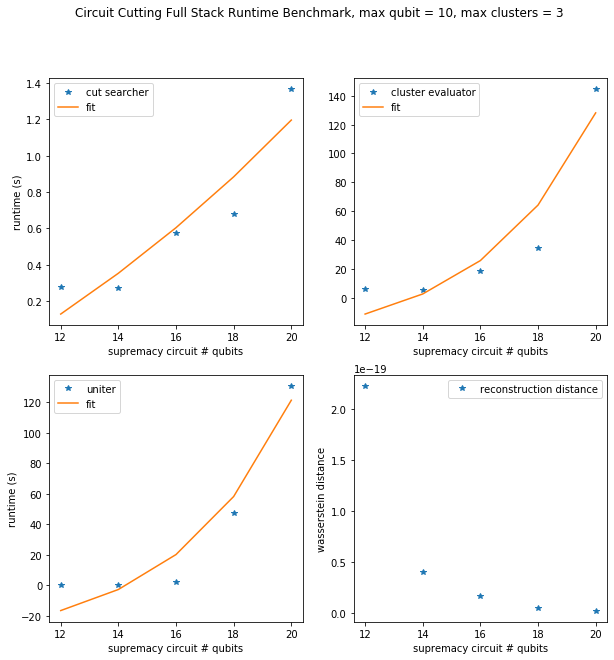

In [2]:
import pickle
import matplotlib.pyplot as plt
import scipy.optimize as opt
import numpy as np

def func(x, a, b):
    return np.exp(a*x)+b

benchmark = pickle.load(open('./data/full_stack_benchmark.p', 'rb' ))
num_qubits,times,noiseless_reconstruction_distance,noisy_reconstruction_distance,full_circ_noisy_noisless_distance = benchmark

# plt.figure(figsize=(10,15))
plt.figure(figsize=(10,10))
plt.subplot(221)
plt.plot(num_qubits,times['searcher'],'*',label='cut searcher')
optimizedParameters, pcov = opt.curve_fit(func, np.array(num_qubits), np.array(times['searcher']))
plt.plot(num_qubits, func(np.array(num_qubits), *optimizedParameters), label="fit")
plt.xlabel('supremacy circuit # qubits')
plt.ylabel('runtime (s)')
plt.legend()
plt.subplot(222)
plt.plot(num_qubits,times['evaluator'],'*',label='cluster evaluator')
optimizedParameters, pcov = opt.curve_fit(func, np.array(num_qubits), np.array(times['evaluator']))
plt.plot(num_qubits, func(np.array(num_qubits), *optimizedParameters), label="fit")
plt.xlabel('supremacy circuit # qubits')
plt.legend()
plt.subplot(223)
plt.plot(num_qubits,times['uniter'],'*',label='uniter')
optimizedParameters, pcov = opt.curve_fit(func, np.array(num_qubits), np.array(times['uniter']))
plt.plot(num_qubits, func(np.array(num_qubits), *optimizedParameters), label="fit")
plt.xlabel('supremacy circuit # qubits')
plt.ylabel('runtime (s)')
plt.legend()
plt.subplot(224)
plt.plot(num_qubits,noiseless_reconstruction_distance,'*',label='reconstruction distance')
plt.xlabel('supremacy circuit # qubits')
plt.ylabel('wasserstein distance')
plt.legend()
plt.suptitle('Circuit Cutting Full Stack Runtime Benchmark, max qubit = 10, max clusters = 3')
plt.savefig('./data/benchmark.png')